# Import packages

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import mean_squared_error, mean_absolute_error, \
    r2_score, make_scorer, recall_score, accuracy_score, f1_score, \
    precision_score, balanced_accuracy_score, roc_curve, auc

# Custom functions

In [2]:
from pickle_managment import save_pickle, load_pickle

# Regression

In [3]:
regression_df_expanded_cleaned = pd.read_csv(
    r'datasets\train_datasets\regression_df_expanded_cleaned_train.csv.zip'
)
regression_df_expanded_cleaned

,SMILES,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,158_y,159_y,160_y,161_y,162_y,163_y,164_y,165_y,166_y,logBB
0,CC(C)(C)OC(=O)CCCC1=CC=C(C=C1)N(CCCl)CCCl,11.682268,11.682268,0.134704,-0.409691,0.474821,11.347826,360.325,333.109,359.141884,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.00
1,Clc1ccc(N2)c(C(C)=NC(O)C2=O)c1,11.306112,11.306112,0.532016,-1.350763,0.700249,20.066667,224.647,215.575,224.035255,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.61
2,CC1=C2OC3=C(C=CC=C3)C3(O)CNCC3C2=CC=C1,11.238358,11.238358,0.028750,-0.893218,0.770818,27.000000,267.328,250.192,267.125929,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.39
3,C[C@H]1[C@H]([C@H](C[C@@H](O1)O[C@H]2C[C@@](CC...,13.643057,13.643057,0.017252,-2.240737,0.235263,29.846154,543.525,514.293,543.174061,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,-0.83
4,CCC1(C(=O)NC(=O)NC1=O)C2=CC=CC=C2,11.975791,11.975791,0.293611,-1.310347,0.736884,18.529412,232.239,220.143,232.084792,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,-0.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,C(=O)(N)N,9.000000,9.000000,0.833333,-0.833333,0.370507,6.000000,60.056,56.024,60.032363,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-0.14
941,C[C@@H](CC1=CC=CC=C1)NC,3.213399,3.213399,0.567037,0.567037,0.691109,12.909091,149.237,134.117,149.120449,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.96
942,CNC(=O)C1=C(N=C(N=C1OCC2CCN(CC2)C)C#N)NCC3CCC4...,12.730831,12.730831,0.023700,-0.298674,0.670950,21.531250,440.592,404.304,440.289974,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.37
943,CCC1=C2C(=CC=C1)C3=C(N2)C(OCC3)(CC)CC(=O)O,11.285827,11.285827,0.004742,-0.820305,0.905784,21.428571,287.359,266.191,287.152144,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,-1.42


In [4]:
regression_X = regression_df_expanded_cleaned.loc[
               :,
               ~regression_df_expanded_cleaned.columns.isin(
                   ['SMILES', 'logBB'])
               ]

regression_y = regression_df_expanded_cleaned['logBB']

regression_X_train, regression_X_test, regression_y_train, regression_y_test = train_test_split(
    regression_X,
    regression_y,
    test_size=0.2,
    random_state=1,
    shuffle=True
)

## Random forest

### Model training

In [5]:
start_time = datetime.now()

rf_regressor = RandomForestRegressor(
    random_state=1
)

rf_regressor_grid_search = GridSearchCV(
    estimator=rf_regressor,
    param_grid={
        'n_estimators': list(range(500, 2000, 1000)),  #Number of trees
        'max_depth': [10],  #The maximum depth of the tree
        # 'min_samples_split': [2, 5], #The minimum number of samples required to split an internal node
        # 'min_samples_leaf': [1, 2], #The minimum number of samples required to be at a leaf node
        # 'criterion': ['squared_error'] # “squared_error” for the mean
        # squared error. This is the default
    },
    cv=2,  #Number of fold for cross validation. It should be 8 or 10
    scoring={
        # All these are only viable in the negative option
        'MAE': 'neg_mean_absolute_error',
        'MSE': 'neg_mean_squared_error',
        'R2': 'r2'
    },
    refit='R2',

    n_jobs=1,
    # -1 means using all processors, but it won't give you any messages.
    # Only using 1 for my computer print out the training messages

    verbose=10  #Provide detailed more messages
)

rf_regressor_grid_search.fit(regression_X_train, regression_y_train)

end_time = datetime.now()
print('GridSearchCV took {}'.format(end_time - start_time))

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV 1/2; 1/2] START max_depth=10, n_estimators=500..............................
[CV 1/2; 1/2] END max_depth=10, n_estimators=500; MAE: (test=-0.387) MSE: (test=-0.277) R2: (test=0.549) total time=  24.8s
[CV 2/2; 1/2] START max_depth=10, n_estimators=500..............................
[CV 2/2; 1/2] END max_depth=10, n_estimators=500; MAE: (test=-0.392) MSE: (test=-0.285) R2: (test=0.465) total time=  24.0s
[CV 1/2; 2/2] START max_depth=10, n_estimators=1500.............................
[CV 1/2; 2/2] END max_depth=10, n_estimators=1500; MAE: (test=-0.386) MSE: (test=-0.277) R2: (test=0.550) total time= 1.3min
[CV 2/2; 2/2] START max_depth=10, n_estimators=1500.............................
[CV 2/2; 2/2] END max_depth=10, n_estimators=1500; MAE: (test=-0.393) MSE: (test=-0.286) R2: (test=0.464) total time= 1.5min
GridSearchCV took 0:04:41.507959


In [6]:
rf_regressor_results_df = pd.DataFrame(rf_regressor_grid_search.cv_results_)
#Make the GridSearch results into a df
rf_regressor_results_df.drop(
    list(rf_regressor_results_df.filter(regex='time|split|std')),
    axis=1,
    inplace=True
)  # Remove columns that aren't very interesting

rf_regressor_results_df = rf_regressor_results_df.sort_values(
    by='rank_test_R2')
rf_regressor_results_df

,param_max_depth,param_n_estimators,params,mean_test_MAE,rank_test_MAE,mean_test_MSE,rank_test_MSE,mean_test_R2,rank_test_R2
0,10,500,"{'max_depth': 10, 'n_estimators': 500}",-0.389565,2,-0.281223,1,0.507290,1
1,10,1500,"{'max_depth': 10, 'n_estimators': 1500}",-0.389239,1,-0.281238,2,0.507201,2


In [7]:
rf_regressor_results_df.to_csv(
    r'model_grid_search\rf_regressor\results.csv',
    index=False
)

In [8]:
best_rf_regressor = rf_regressor_grid_search.best_estimator_
save_pickle(
    best_rf_regressor,
    r'model_pickles\rf_regressor\best_rf_regressor.pkl'
)
# To load this best model again, use load_pickle(r'model_pickles\random_forest_regressor\best_rf_regressor.pkl')

0

### Model interpretation

In [11]:
best_rf_regressor = load_pickle(
    r'model_pickles\rf_regressor\best_rf_regressor.pkl')

In [12]:
importance = best_rf_regressor.feature_importances_.copy()  #Length of
# importance should be the same as your regression_X_train's number of features
non_zero_index_list = [i for i, v in enumerate(importance) if v != 0]  #Only
# care about the important ones


non_zero_feature_names = [regression_X_train.columns[i] for i in
                          non_zero_index_list]
non_zero_importance = [importance[i] for i in non_zero_index_list]

non_zero_importance_df = pd.DataFrame(
    data=dict(
        zip(
            ['Features', 'Importance'],
            [non_zero_feature_names, non_zero_importance]
        )
    )
)

non_zero_importance_df = non_zero_importance_df.sort_values(
    by='Importance',
    ascending=False
)
non_zero_importance_df = non_zero_importance_df.reset_index(drop=True)  #Reset
# the index and drop the old index
non_zero_importance_df = non_zero_importance_df.head(20)
non_zero_importance_df

,Features,Importance
0,TPSA,0.406881
1,PEOE_VSA6,0.016769
2,VSA_EState7,0.014313
3,MolLogP,0.013893
4,Kappa2,0.011228
5,BCUT2D_MWLOW,0.010228
6,BCUT2D_MRHI,0.009959
7,PEOE_VSA8,0.009514
8,FpDensityMorgan2,0.009465
9,BCUT2D_MWHI,0.009091


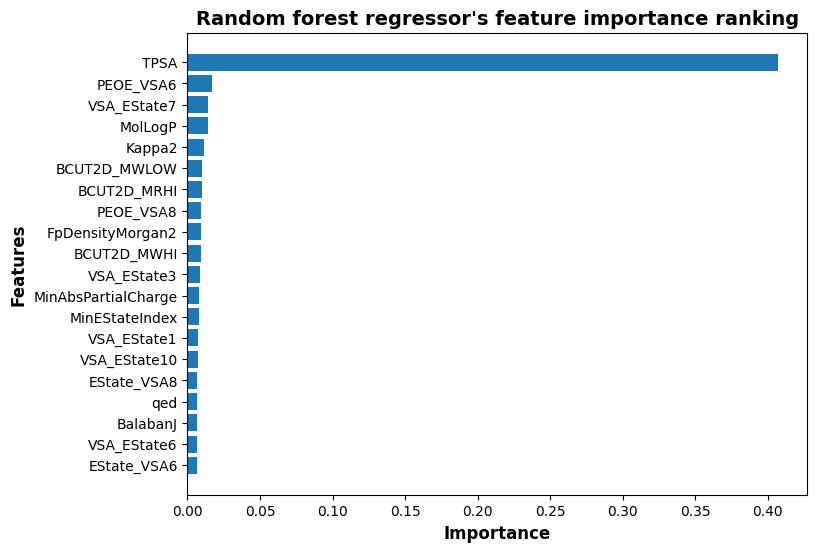

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.barh(non_zero_importance_df['Features'],
         non_zero_importance_df['Importance'])

ax.invert_yaxis()  #Flip the y-axis so the most important feature is on the top

plt.xlabel('Importance', weight='bold', fontsize=12)
plt.ylabel('Features', weight='bold', fontsize=12)
plt.title("Random forest regressor's feature importance ranking",
          weight='bold', fontsize=14)

plt.savefig(
    r'model_outputs\rf_regressor\importance_ranking_vertical.png',
    dpi=600,
    bbox_inches='tight'
)

plt.show()

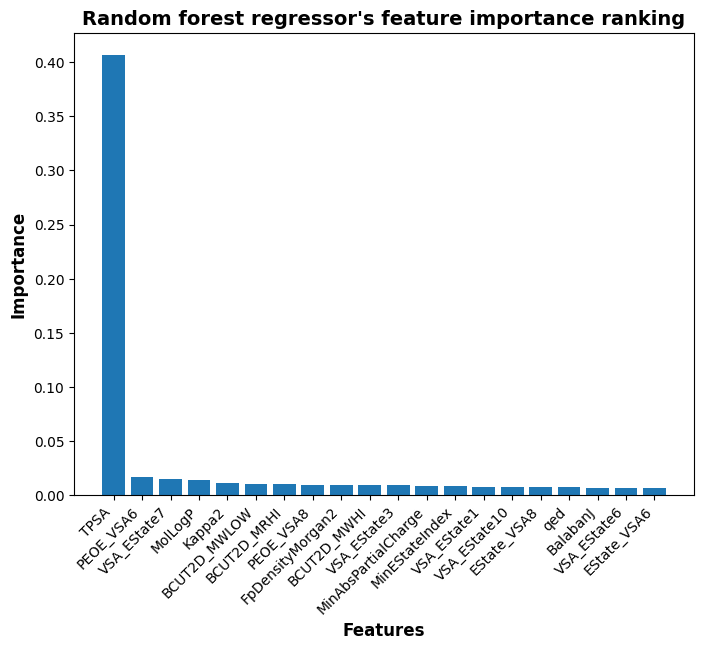

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.bar(non_zero_importance_df['Features'],
        non_zero_importance_df['Importance'])

plt.xticks(rotation=45, ha='right')

plt.xlabel('Features', weight='bold', fontsize=12)
plt.ylabel('Importance', weight='bold', fontsize=12)
plt.title("Random forest regressor's feature importance ranking",
          weight='bold', fontsize=14)

plt.savefig(
    r'model_outputs\rf_regressor\importance_ranking_horizontal.png',
    dpi=600,
    bbox_inches='tight'
)

plt.show()

Top most important feature is the TPSA (topological polar surface area),
which indicates the drug's polarity. This make sense because the drug
polarity should dramatically influence its ability to pass through BBB.

# Classification

## Neural network

In [15]:
classification_df_expanded_balanced = pd.read_csv(
    r'datasets\balanced_datasets\BBB_classification_balanced_centroid.csv.zip'
)
classification_df_expanded_balanced

,SMILES,BBB+/BBB-,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,...,157_y,158_y,159_y,160_y,161_y,162_y,163_y,164_y,165_y,166_y
0,CN[C@@H]1[C@H](O[C@H]2[C@H](O[C@@H]3[C@H](NC(=...,BBB+,9.095732,9.095732,0.282774,-0.017526,0.586761,11.860043,358.488,332.280,...,0.333333,1.0,0.666667,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,CCCCC[C@H](N)C(O)(c1ccccc1)c1ccccc1,BBB+,15.143070,15.143070,0.021937,-1.615734,0.147925,26.905882,1202.635,1090.747,...,1.000000,1.0,1.000000,1.0,1.0,0.0,0.0,1.0,1.0,0.0
2,Cc1nnc(SCC2=C(C(=O)O)N3C(=O)[C@@H](NC(=O)[C@H]...,BBB+,15.022344,15.022344,0.036460,-1.947471,0.109538,42.500000,1085.156,1008.548,...,1.000000,0.0,1.000000,1.0,0.0,1.0,1.0,1.0,1.0,0.0
3,C[C@@H]1C[C@H]2[C@@H]3C[C@H](F)C4=CC(=O)C(Cl)=...,BBB+,14.543654,14.543654,0.006968,-2.468650,0.116173,36.726027,1030.303,942.607,...,1.000000,1.0,1.000000,1.0,1.0,0.0,1.0,1.0,1.0,0.0
4,CC(C)=CCN1Cc2cc(Cl)cc3[nH]c(=S)n(c23)C[C@@H]1C,BBB+,14.995286,14.995286,0.035518,-1.944947,0.109538,42.500000,1085.156,1008.548,...,1.000000,0.0,1.000000,1.0,0.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5127,CC1CC2C(C(O)CC3(C)C2CCC3(O)C(=O)CO)C2(C)C=CC(=...,BBB-,12.428253,12.428253,0.083608,-1.721468,0.122643,47.948718,569.609,526.265,...,1.000000,1.0,1.000000,1.0,1.0,0.0,1.0,1.0,1.0,0.0
5128,CC[C@H]1CC(=O)[C@@H]2Oc3c(OC)ccc4c3[C@@]23CCN(...,BBB-,12.559895,12.559895,0.048057,-3.487690,0.443295,22.448276,440.503,420.343,...,1.000000,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,0.0
5129,CN(C)C=Nc1c(I)cc(I)c(CCC(=O)O)c1I,BBB-,12.935121,12.935121,0.008292,-0.854188,0.192994,15.076923,551.769,498.345,...,1.000000,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,0.0
5130,CC(=O)Oc1ccc(C(=C2CCCCC2)c2ccc(OC(C)=O)cc2)cc1,BBB-,13.042813,13.042813,0.190845,-3.798036,0.233814,31.275000,594.668,564.428,...,1.000000,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [16]:
# Data pre-processing. This will make the model less interpretable but since
# MLP is already less interpretable than RF, this is fine since I will try
# to use another RF to explain why MLP made such decision

classification_X = classification_df_expanded_balanced.loc[
                   :,
                   ~classification_df_expanded_balanced.columns.isin(
                       ['SMILES', 'BBB+/BBB-'])
                   ]

classification_y = classification_df_expanded_balanced['BBB+/BBB-']


data_processing_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(
        n_components=0.95, #When using the svd_solver='full', n_components
        # can be between 0 and 1 to represent the percentage of variance
        # that you want to explain
        svd_solver='full'
    ))
])

classification_X_processed=data_processing_pipeline.fit_transform(classification_X)
classification_X_processed

array([[-5.21368953,  3.62439041,  3.83142447, ..., -0.28812032,
         1.01953803,  1.14219888],
       [26.17726014,  2.11795901,  7.38495038, ..., -0.06678346,
        -0.10646903,  0.11734033],
       [30.11439095, -6.29187033, 11.81692613, ...,  0.16951343,
         0.13249661, -0.20160932],
       ...,
       [ 4.95976758, -2.1562782 ,  4.54480143, ...,  0.19877777,
         0.478151  ,  0.5183374 ],
       [ 9.25061068,  9.77543853, -4.86349062, ...,  0.56208832,
        -0.43130308, -0.22326148],
       [-4.13634063,  2.39963095,  3.04815532, ..., -0.65332458,
         0.38452521,  0.0315058 ]])

In [17]:
classification_X_train, classification_X_test, classification_y_train, classification_y_test = train_test_split(
    classification_X_processed,
    classification_y,
    test_size=0.2,
    random_state=1,
    shuffle=True,
    stratify=classification_y #Ensure train set and test set have the same
    # ratio for the 2 categories
)

### Model training

In [27]:
start_time = datetime.now()

mlp_classifier = MLPClassifier(
    solver='adam',
    #"adam" is the default. It works pretty well on relatively large datasets (with thousands of training samples or more) in terms of both training time and validation score
    random_state=1,
    shuffle=True,  #shuffle samples in each iteration for "adam" solver
)

mlp_classifier_grid_search = GridSearchCV(
    estimator=mlp_classifier,
    param_grid={
        'hidden_layer_sizes': [(50,), (50,50)], #(200,), (200,100)],
        'alpha': [1e-4],# 1e-5],
        'activation': [
            'relu', #"relu" is the default
            # 'tanh'
        ]
    },
    cv=RepeatedStratifiedKFold(
        n_splits=3,
        n_repeats=2, #Each time the split will be different
        random_state=1
    ),
    scoring={
        'Recall': make_scorer(
            recall_score, #Need pos_label
            pos_label='BBB+', #Without this, pos_label is default to be 1
            # and will through an error since 1 isn't "BBB+" or "BBB-"
            average='binary'
        ),
        'Precision': make_scorer(
            precision_score, #Need pos_label
            pos_label='BBB+',
            average='binary'
        ),
        'F1': make_scorer(
            f1_score, #Need pos_label
            pos_label='BBB+',
            average='binary'
        ),
        'Accuracy': 'accuracy', #accuracy_score doesn't need pos_label
        'Balanced accuracy': 'balanced_accuracy',
        'AUROC': 'roc_auc'
    },
    refit='AUROC',

    n_jobs=1,
    verbose=10
)

mlp_classifier_grid_search.fit(classification_X_train, classification_y_train)

end_time = datetime.now()
print('GridSearchCV took {}'.format(end_time - start_time))

[CV 2/6; 2/8] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50); AUROC: (test=0.923) Accuracy: (test=0.854) Balanced accuracy: (test=0.854) F1: (test=0.859) Precision: (test=0.830) Recall: (test=0.890) total time=   8.8s
[CV 3/6; 2/8] START activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50)..
[CV 3/6; 2/8] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50); AUROC: (test=0.906) Accuracy: (test=0.844) Balanced accuracy: (test=0.844) F1: (test=0.849) Precision: (test=0.826) Recall: (test=0.873) total time=   7.8s
[CV 4/6; 2/8] START activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50)..
[CV 4/6; 2/8] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50); AUROC: (test=0.912) Accuracy: (test=0.833) Balanced accuracy: (test=0.833) F1: (test=0.839) Precision: (test=0.809) Recall: (test=0.872) total time=   4.1s
[CV 5/6; 2/8] START activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50)..
[CV 5/6; 2/8] END activation=relu, alpha=0.0001, hidden

In [28]:
mlp_classifier_results_df = pd.DataFrame(mlp_classifier_grid_search.cv_results_)
#Make the GridSearch results into a df

mlp_classifier_results_df.drop(
    list(mlp_classifier_results_df.filter(regex='time|split|std')),
    axis=1,
    inplace=True
)  # Remove columns that aren't very interesting
mlp_classifier_results_df = mlp_classifier_results_df.sort_values(
    by='rank_test_AUROC')

mlp_classifier_results_df

,param_activation,param_alpha,param_hidden_layer_sizes,params,mean_test_Recall,rank_test_Recall,mean_test_Precision,rank_test_Precision,mean_test_F1,rank_test_F1,mean_test_Accuracy,rank_test_Accuracy,mean_test_Balanced accuracy,rank_test_Balanced accuracy,mean_test_AUROC,rank_test_AUROC
7,tanh,0.00001,"(50, 50)","{'activation': 'tanh', 'alpha': 1e-05, 'hidden...",0.861907,6,0.821201,5,0.840944,6,0.837029,6,0.837021,5,0.917556,1
5,tanh,0.0001,"(50, 50)","{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",0.858741,7,0.821447,2,0.839566,7,0.835933,7,0.835925,7,0.917254,2
4,tanh,0.0001,"(50,)","{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",0.862151,4,0.821377,3,0.841146,4,0.837152,4,0.837143,4,0.915615,3
6,tanh,0.00001,"(50,)","{'activation': 'tanh', 'alpha': 1e-05, 'hidden...",0.862150,5,0.821193,6,0.841042,5,0.837030,5,0.837020,6,0.915359,4
3,relu,0.00001,"(50, 50)","{'activation': 'relu', 'alpha': 1e-05, 'hidden...",0.875303,1,0.822303,1,0.847937,1,0.842998,1,0.842988,1,0.911880,5
1,relu,0.0001,"(50, 50)","{'activation': 'relu', 'alpha': 0.0001, 'hidde...",0.874815,2,0.821301,4,0.847153,2,0.842145,2,0.842135,2,0.911770,6
2,relu,0.00001,"(50,)","{'activation': 'relu', 'alpha': 1e-05, 'hidden...",0.874082,3,0.818714,7,0.845382,3,0.840074,3,0.840062,3,0.908929,7
0,relu,0.0001,"(50,)","{'activation': 'relu', 'alpha': 0.0001, 'hidde...",0.843623,8,0.782371,8,0.811676,8,0.803159,8,0.803147,8,0.864458,8


,param_activation,param_alpha,param_hidden_layer_sizes,params,mean_test_Recall,rank_test_Recall,mean_test_Precision,rank_test_Precision,mean_test_F1,rank_test_F1,mean_test_Accuracy,rank_test_Accuracy,mean_test_Balanced accuracy,rank_test_Balanced accuracy,mean_test_AUROC,rank_test_AUROC
1,relu,0.0001,"(50, 50)","{'activation': 'relu', 'alpha': 0.0001, 'hidde...",0.874815,1,0.821301,1,0.847153,1,0.842145,1,0.842135,1,0.911770,1
0,relu,0.0001,"(50,)","{'activation': 'relu', 'alpha': 0.0001, 'hidde...",0.873838,2,0.818861,2,0.845343,2,0.840074,2,0.840062,2,0.908954,2


In [29]:
mlp_classifier_results_df.to_csv(
    r'model_grid_search\mlp_classifier\results.csv',
    index=False
)

In [30]:
best_mlp_classifier = mlp_classifier_grid_search.best_estimator_
save_pickle(
    best_mlp_classifier,
    r'model_pickles\mlp_classifier\best_mlp_classifier.pkl'
)
# To load this best model again, use load_pickle(r'model_pickles\multiple_layer_perceptron_classifier\best_mlp_classifier.pkl')

0

0

### Model interpretation

In [31]:
best_mlp_classifier = load_pickle(
    r'model_pickles\mlp_classifier\best_mlp_classifier'
    r'.pkl')

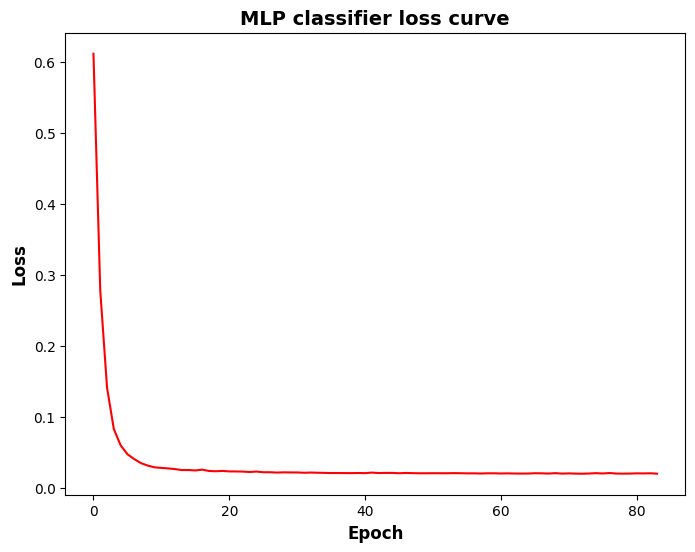

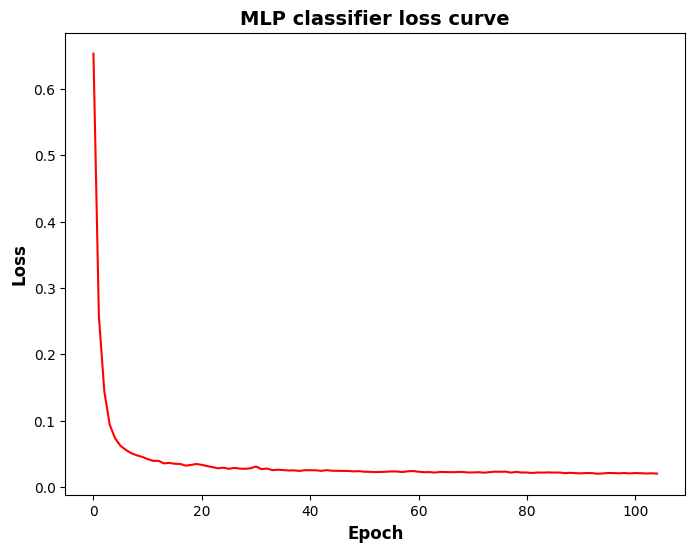

In [32]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(
    best_mlp_classifier.loss_curve_,
    color='red'
)
plt.xlabel('Epoch',weight='bold', fontsize=12)
plt.ylabel('Loss',weight='bold', fontsize=12)
plt.title('MLP classifier loss curve', weight='bold', fontsize=14)

plt.savefig(
    r'model_outputs\mlp_classifier'
    r'\loss_curve'
    r'.png',
    dpi=600,
    bbox_inches='tight'
)

plt.show()

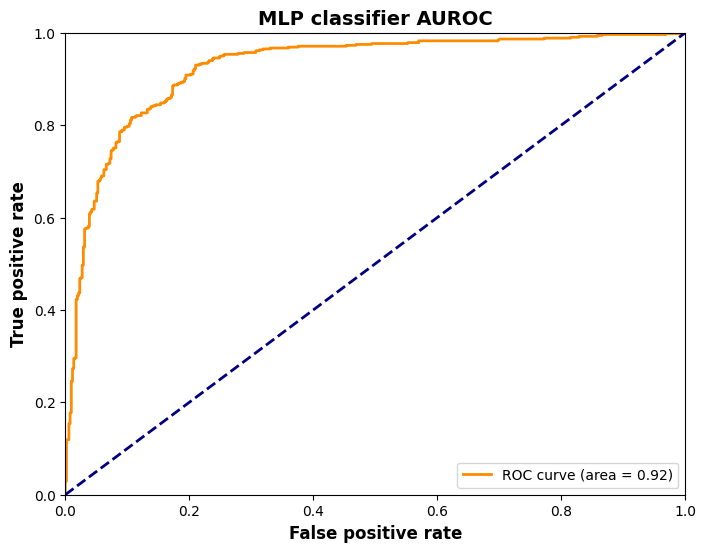

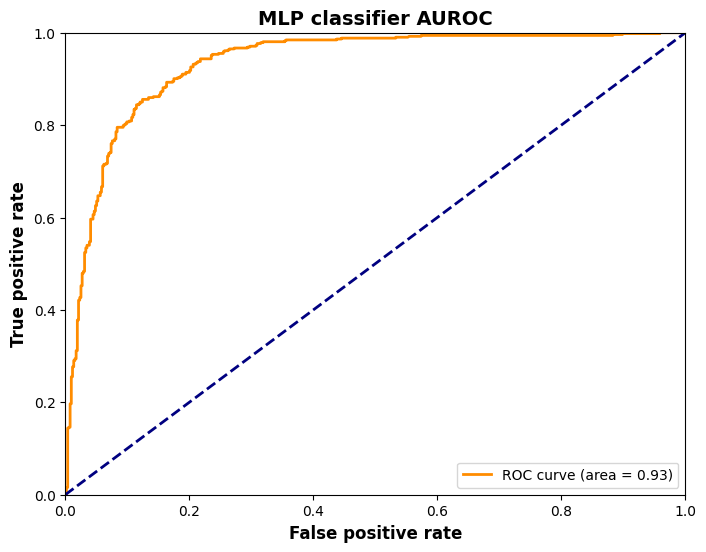

In [33]:
positive_label_index = np.where(best_mlp_classifier.classes_ == 'BBB+')[0][0]
y_probabilities = best_mlp_classifier.predict_proba(classification_X_test)[:, positive_label_index]

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(classification_y_test, y_probabilities,
                        pos_label='BBB+')
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(
    fpr,
    tpr,
    color='darkorange',
    lw=2,
    label='ROC curve (area = %0.2f)' % roc_auc
)
plt.plot(
    [0, 1],
    [0, 1],
    color='navy',
    lw=2,
    linestyle='--'
)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False positive rate',weight='bold', fontsize=12)
plt.ylabel('True positive rate',weight='bold', fontsize=12)
plt.title('MLP classifier AUROC',weight='bold', fontsize=14)
plt.legend(loc='lower right')

plt.savefig(
    r'model_outputs\mlp_classifier'
    r'\auroc'
    r'.png',
    dpi=600,
    bbox_inches='tight'
)

plt.show()